# Setup

In [1]:
import os
import zipfile
import sys
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from keras import backend, models, layers, initializers, regularizers, constraints, optimizers
from keras import callbacks as kc
from keras import optimizers as ko
from sklearn.metrics import log_loss
from sklearn.model_selection import cross_val_score, KFold, train_test_split

/Users/aarontrefler_temp2/anaconda/envs/py35/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)
Using TensorFlow backend.


In [3]:
proj_path = "/Users/aarontrefler_temp2/Documents/My_Documents/Kaggle/kaggle-gendered-pronoun/"
sys.path.insert(0, proj_path)

In [4]:
import bert.modeling
import bert.extract_features
import bert.tokenization

import src.utils as utils
import src.data.data_utils as data_utils
import src.models.bert_model_utils as bert_model_utils
import src.models.keras_model_utils as keras_model_utils

In [5]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

pd.options.display.max_columns = 20

In [6]:
bert_dir = proj_path + "bert/"

data_raw_dir = proj_path + "data/raw/"
data_interim_dir = proj_path + "data/interim/"
data_clean_dir = proj_path + "data/clean/"

models_dir = proj_path + "models/"

# Read Data

In [7]:
df_train = pd.read_csv(proj_path + "data/raw/gap-test.tsv", sep='\t')
df_valid = pd.read_csv(proj_path + "data/raw/gap-validation.tsv", sep='\t')
df_test = pd.read_csv(proj_path + "data/raw/gap-development.tsv", sep='\t')

In [8]:
utils.display_df(df_train, title="Train - GAP Test")
utils.display_df(df_valid, title="Validation - GAP Validation")
utils.display_df(df_test, title="Test - GAP Development")

Train - GAP Test:


,ID,Text,Pronoun,Pronoun-offset,A,A-offset,A-coref,B,B-offset,B-coref,URL
0,test-1,Upon their acceptance into the Kontinental Hoc...,His,383,Bob Suter,352,False,Dehner,366,True,http://en.wikipedia.org/wiki/Jeremy_Dehner


(2000, 11)

Validation - GAP Validation:


,ID,Text,Pronoun,Pronoun-offset,A,A-offset,A-coref,B,B-offset,B-coref,URL
0,validation-1,He admitted making four trips to China and pla...,him,256,Jose de Venecia Jr,208,False,Abalos,241,False,http://en.wikipedia.org/wiki/Commission_on_Ele...


(454, 11)

Test - GAP Development:


,ID,Text,Pronoun,Pronoun-offset,A,A-offset,A-coref,B,B-offset,B-coref,URL
0,development-1,Zoe Telford -- played the police officer girlf...,her,274,Cheryl Cassidy,191,True,Pauline,207,False,http://en.wikipedia.org/wiki/List_of_Teachers_...


(2000, 11)

In [9]:
df_train.Text[0]

"Upon their acceptance into the Kontinental Hockey League, Dehner left Finland to sign a contract in Germany with EHC M*nchen of the DEL on June 18, 2014. After capturing the German championship with the M*nchen team in 2016, he left the club and was picked up by fellow DEL side EHC Wolfsburg in July 2016. Former NHLer Gary Suter and Olympic-medalist Bob Suter are Dehner's uncles. His cousin is Minnesota Wild's alternate captain Ryan Suter."

## Describe Raw Data

In [10]:
def describe_raw_data(df):
    df.Pronoun.str.lower().hist(bins=20)

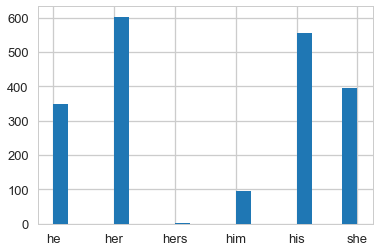

In [11]:
describe_raw_data(df_train)

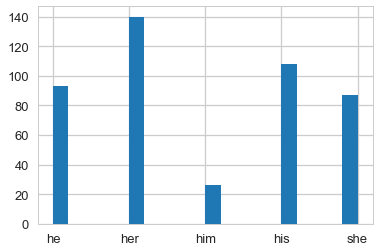

In [12]:
describe_raw_data(df_valid)

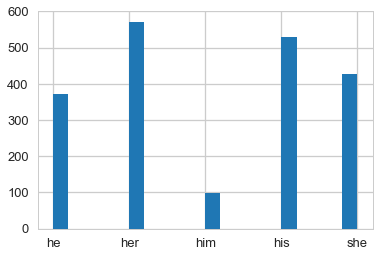

In [13]:
describe_raw_data(df_test)

# Extract BERT Word Embedding Features

In [14]:
# Create bert extract features input text files
df_train.Text.to_csv(data_interim_dir + "input_train.txt", index = False, header = False)
df_valid.Text.to_csv(data_interim_dir + "input_valid.txt", index = False, header = False)
df_test.Text.to_csv(data_interim_dir + "input_test.txt", index = False, header = False)

In [15]:
def create_bert_extract_features_cmd(df, dataset_name):

    extract_features_cmd = "python {extract_features_script} \
      --input_file={input_file} \
      --output_file={output_file} \
      --vocab_file={vocab_file} \
      --bert_config_file={bert_config_file} \
      --init_checkpoint={init_checkpoint} \
      --layers=-1 \
      --max_seq_length=256 \
      --batch_size=8".format(
        extract_features_script = bert_dir + "extract_features.py",
        input_file = data_interim_dir + "input_{dataset}.txt".format(dataset=dataset_name),
        output_file = data_interim_dir + "output_{dataset}.json".format(dataset=dataset_name),
        vocab_file = models_dir + "uncased_L-12_H-768_A-12/vocab.txt",
        bert_config_file = models_dir + "uncased_L-12_H-768_A-12/bert_config.json",
        init_checkpoint = models_dir + "uncased_L-12_H-768_A-12/bert_model.ckpt"    
    )

    return extract_features_cmd


In [ ]:
# Create BERT feature extraction commands
train_bert_extract_features_cmd = create_bert_extract_features_cmd(df_train, "train")
valid_bert_extract_features_cmd = create_bert_extract_features_cmd(df_valid, "valid")
test_bert_extract_features_cmd = create_bert_extract_features_cmd(df_test, "test")

# Execute commands in terminal
print(train_bert_extract_features_cmd)
print(valid_bert_extract_features_cmd)
print(test_bert_extract_features_cmd)

In [17]:
# Read in BERT features
train_bert_features = bert_model_utils.read_in_bert_features(dataset_name="train")
valid_bert_features = bert_model_utils.read_in_bert_features(dataset_name="valid")
test_bert_features = bert_model_utils.read_in_bert_features(dataset_name="test")

# Manipulate BERT features to create word embedding dataframes
df_train_emb = bert_model_utils.create_bert_word_embedding_df(
    df=df_train, bert_output=train_bert_features, dataset_name="train")
df_valid_emb = bert_model_utils.create_bert_word_embedding_df(
    df=df_valid, bert_output=valid_bert_features, dataset_name="valid")
df_test_emb =bert_model_utils.create_bert_word_embedding_df(
    df=df_test, bert_output=test_bert_features, dataset_name="test")

# Save word embedding dataframes to json files
df_train_emb.to_json(data_interim_dir + "contextual_embeddings_gap_train.json", orient = 'columns')
df_valid_emb.to_json(data_interim_dir + "contextual_embeddings_gap_valid.json", orient = 'columns')
df_test_emb.to_json(data_interim_dir + "contextual_embeddings_gap_test.json", orient = 'columns')

/Users/aarontrefler_temp2/Documents/My_Documents/Kaggle/kaggle-gendered-pronoun/src/models/bert_model_utils.py:68: RuntimeWarning: invalid value encountered in true_divide
  emb_B /= cnt_B


KeyboardInterrupt: 

In [ ]:
utils.display_df(df_train_emb, title="Train - GAP Test")
utils.display_df(df_valid_emb, title="Validation - GAP Validation")
utils.display_df(df_test_emb, title="Test - GAP Development")

In [18]:
# Read development embeddigns from json file - this is the output of Bert
X_train, Y_train = bert_model_utils.parse_json(
    pd.read_json(data_interim_dir + "contextual_embeddings_gap_train.json"))
X_valid, Y_valid = bert_model_utils.parse_json(
    pd.read_json(data_interim_dir + "contextual_embeddings_gap_valid.json"))
X_test, Y_test = bert_model_utils.parse_json(
    pd.read_json(data_interim_dir + "contextual_embeddings_gap_test.json"))

# Describe Features

## Missing Values

In [25]:
def describe_missing_values(X):
    nan_rows = [row for row in range(len(X)) if np.isnan(X[row]).sum()]
    
    print("Number of examples with missing values: {num}".format(num=len(nan_rows)))
    if len(nan_rows) > 0:
        sns.heatmap(X[nan_rows])

Number of examples with missing values: 1


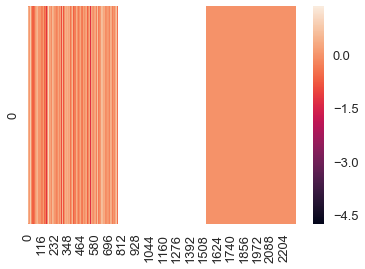

In [26]:
describe_missing_values(X_train)

In [27]:
describe_missing_values(X_valid)

Number of examples with missing values: 0


Number of examples with missing values: 2


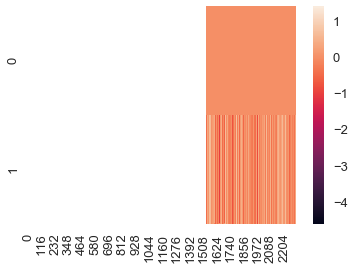

In [28]:
describe_missing_values(X_test)

In [29]:
from sklearn.impute import SimpleImputer

imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(X_train)

# Fill in missing data
X_train_fill = imp.transform(X_train)
X_valid_fill = imp.transform(X_valid)
X_test_fill = imp.transform(X_test)

## Visualize Features

In [30]:
def visualize_data(X):
    sns.heatmap(X, vmin=-4.5, vmax=4.5)

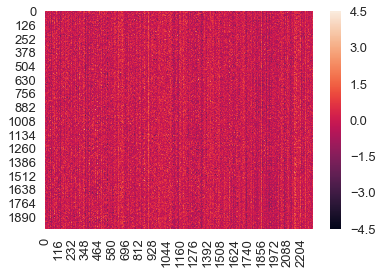

In [31]:
visualize_data(X_train_fill)

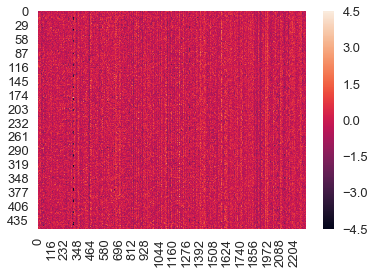

In [32]:
visualize_data(X_valid_fill)

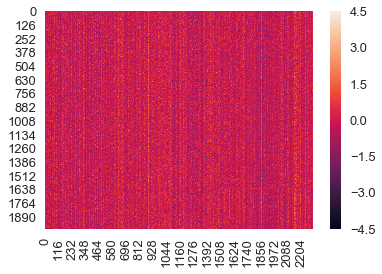

In [33]:
visualize_data(X_test_fill)

# Save Clean Dataset

In [35]:
np.savetxt(data_clean_dir + "X_train.csv", X_train_fill, delimiter=",")
np.savetxt(data_clean_dir + "X_valid.csv", X_valid_fill, delimiter=",")
np.savetxt(data_clean_dir + "X_test.csv", X_test_fill, delimiter=",")

np.savetxt(data_clean_dir + "Y_train.csv", Y_train, delimiter=",")
np.savetxt(data_clean_dir + "Y_valid.csv", Y_valid, delimiter=",")
np.savetxt(data_clean_dir + "Y_test.csv", Y_test, delimiter=",")